In [3]:
# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx
import seaborn as sns
from IPython.display import HTML
from matplotlib import animation

# Setup

## Parameters

In [49]:
iterations=1000
nnodes=100
p_link=.1
leak=.25 #
lrate_wmat=.1
lrate_targ=.01
targ_min=1
sens_offset=20
rot_amp=10
forward_amp=.1
input_amp=5

## Plotting

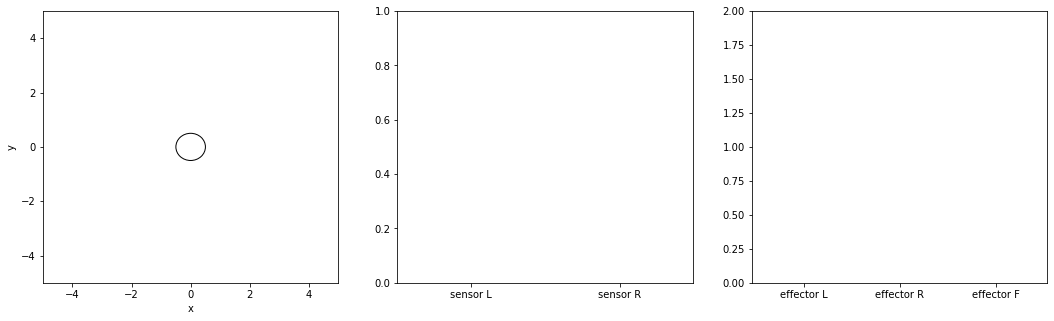

In [50]:
# create a figure and axes
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

# set up the subplots as needed
ax1.set_xlim(( -5, 5))            
ax1.set_ylim((-5, 5))
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_ylim((0, 1))
ax3.set_ylim((0, 2))

circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(circle1)

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
pt1, = ax1.plot([], [], 'g.', ms=30)
sL, = ax1.plot([],[], 'r.', ms =10)
sR, = ax1.plot([],[], 'b.', ms =10)
bar1_plt2, bar2_plt2 = ax2.bar(['sensor L', 'sensor R'],[0,0])
bar1_plt3, bar2_plt3, bar3_plt3 = ax3.bar(['effector L', 'effector R', 'effector F'],[0,0,0])

## Set up sensor nodes and input connections

In [51]:
sensory_nodes=[]
input_wmat=np.zeros((2,nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]
        if input_wmat[row,col] > 0:
            sensory_nodes.append(col)
        
#select two random nodes to be output nodes
output_nodes = random.sample(range(1, nnodes), 3)
while (output_nodes[0] in sensory_nodes) or (output_nodes[1] in sensory_nodes) or (output_nodes[2] in sensory_nodes):
    output_nodes = random.sample(range(1, nnodes), 3)

np.unique(sensory_nodes)
#output_nodes

array([ 0,  7, 10, 13, 15, 16, 24, 27, 32, 34, 41, 45, 46, 58, 67, 69, 74,
       86])

In [52]:
output_nodes

[78, 44, 52]

## Set up internal weight matrix

In [53]:
link_mat = np.zeros((nnodes,nnodes))
for row in range(link_mat.shape[0]):
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
# link_mat[:,:]=1
# np.fill_diagonal(link_mat,0)
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] = np.random.normal(0,1)
            
start_wmat=wmat.copy()

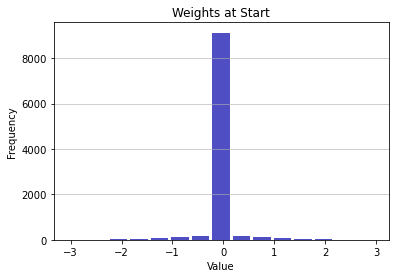

In [54]:
# hist of wmat
n, bins, patches = plt.hist(x=np.matrix.flatten(wmat), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Weights at Start')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

## Functions

In [55]:
def get_plot_vals(degree, heading, position):
    
    x = 3*np.cos(np.radians(degree))
    y = 3*np.sin(np.radians(degree))
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    sLx = .5*np.cos(np.radians(sLdeg)) + position[0]
    sLy = .5*np.sin(np.radians(sLdeg)) + position[1]
    sLpos = np.array([sLx,sLy])
    
    sRx = .5*np.cos(np.radians(sRdeg)) + position[0]
    sRy = .5*np.sin(np.radians(sRdeg)) + position[1]
    sRpos = np.array([sRx, sRy])
    
    return x, y, sLx, sLy, sRx, sRy

def euc_dist(point1, point2):
    xdiff = abs(point1[0] - point2[0])
    ydiff = abs(point1[1] - point2[1])
    euc_dist = np.sqrt(xdiff**2 + ydiff**2)
    
    return euc_dist

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def toroidal_dist(point1, point2):
    game_width = 5
    game_height = 5

    xdiff = abs(point1[0] - point2[0])
    if xdiff > (game_width / 2):
        xdiff = game_width - xdiff

    ydiff = abs(point1[1] - point2[1])
    if ydiff > (game_height / 2):
        ydiff = game_height - ydiff
    
    torus_dist = np.sqrt(xdiff**2 + ydiff**2)

    return torus_dist

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def get_input_acts(heading, position, degree, stim_pos):
#     sLdeg = heading + sens_offset
#     if sLdeg > 360:
#         sLdeg = sLdeg - 360
        
#     angDistL = abs(sLdeg - degree)
#     if angDistL > 180:
#         angDistL = 360 - angDistL
    
#     sRdeg = heading - sens_offset
#     if sRdeg < 0:
#         sRdeg = 360 + sRdeg
        
#     angDistR = abs(sRdeg - degree)
#     if angDistR > 180:
#         angDistR = 360 - angDistR
    
    sRx = .5*np.cos(np.radians(sRdeg))+position[0]
    sRy = .5*np.sin(np.radians(sRdeg))+position[1]
    sRpos = np.array([sRx, sRy])
    
    sLx = .5*np.cos(np.radians(sLdeg)) +position[0]
    sLy = .5*np.sin(np.radians(sLdeg)) + position[1]
    sLpos = np.array([sLx,sLy])
    
    #dR = toroidal_dist(sRpos, np.array(stim_pos))#np.sqrt(np.sum(np.sqrt(np.array(stim_pos)-np.array([s1x,s1y]))))
    #dL = toroidal_dist(sLpos, np.array(stim_pos))#np.sqrt(np.sum(np.sqrt(np.array(stim_pos)-np.array([s2x,s2y]))))

    dR = euc_dist(sRpos, np.array(stim_pos))#np.sqrt(np.sum(np.sqrt(np.array(stim_pos)-np.array([s1x,s1y]))))
    dL = euc_dist(sLpos, np.array(stim_pos))#np.sqrt(np.sum(np.sqrt(np.array(stim_pos)-np.array([s2x,s2y]))))

    
    angDistL = angle_between(sLpos, stim_pos)
    angDistR = angle_between(sRpos, stim_pos)
    
    #sR_act = 1 - angDistRdR/np.sqrt(50)
    #sL_act = 1 - dL/np.sqrt(50)
    
    sL_act = (1 - angDistL/180)*(1 - dL/np.sqrt(50))
    sR_act = (1 - angDistR/180)*(1 - dR/np.sqrt(50))
    
    return [sL_act, sR_act], [dL, dR]

def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets):
    acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    
    thresholds = targets*2
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1]
    acts[acts<0]=0
       
    errors=acts-targets
    
    output_acts = acts[output_nodes]
    output_spikes = spikes[output_nodes]
    
    return acts, spikes, errors, output_acts, output_spikes

def learning(learn_on,link_mat,prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            d_wmat = np.zeros((nnodes,nnodes))
            d_wmat[:,:]=errors*lrate_wmat
            d_wmat[link_mat==0]=0
            d_wmat[prev_inactive,:]=0
            d_wmat=(d_wmat/active_neighbors)
            d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat
            
        targets=targets+(errors*lrate_targ)
        targets[targets<targ_min]=targ_min
        
    return wmat, targets

def move_stim(degree):
    degree += 1
    if degree == 360:
        degree = 0
    if degree == -1:
        degree = 359

    return degree

def move_agent(output_acts, output_spikes, heading, position):
    
    diff = (output_acts[0] - output_acts[1])*rot_amp #rotates clockwise when left sensor is more active
    #diff = output_spikes[0] - output_spikes[1]
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
        
    r = output_acts[2]*forward_amp
    dx = r * np.cos(np.radians(heading))
    dy = r * np.sin(np.radians(heading))
    position[0]+= dx
    position[1]+= dy
    
    #for toroidal dist
#     if position[0]>5:
#         position[0]-=10
#     if position[0]<-5:
#         position[0]+=10
#     if position[1]>5:
#         position[1]-=10
#     if position[1]<-5:
#         position[1]+=10

    # for euc dist
    if position[0] > 5:
        position[0] = 5
        
    if position[0] < -5:
        position[0] = -5
        
    if position[1] > 5:
        position[1] = 5
        
    if position[1] < -5:
        position[1] = -5
    
    return heading, position


# Run the model

In [46]:
start_input_acts = pd.DataFrame()
start_output_acts = pd.DataFrame()
start_spikes=pd.DataFrame()
start_acts=pd.DataFrame()
start_targets=pd.DataFrame()
start_errors=pd.DataFrame()
start_tprobs=pd.DataFrame()

start_input_acts = pd.DataFrame()
start_output_acts = pd.DataFrame()
end_spikes=pd.DataFrame()
end_acts=pd.DataFrame()
end_targets=pd.DataFrame()
end_errors=pd.DataFrame()
end_tprobs=pd.DataFrame()

spikes=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(2)
# output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]

i=1
degree = 0
heading = 0
position = [0,0]
learn_on=1
stim_pos = [3*np.cos(np.radians(0)),3*np.sin(np.radians(0))]
def drawframe(n):
    global circle1,degree, heading, position, stim_pos,acts, input_acts, output_acts, output_spikes,leak, spikes, prev_spikes, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs
    
    input, dists = get_input_acts(heading, position, degree, stim_pos)
        
    prev_spikes = spikes.copy()
    
    acts, spikes, errors, output_acts, output_spikes = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
    
    wmat, targets = learning(learn_on,link_mat,prev_spikes, errors, wmat,targets)
    
    x, y, sLx, sLy, sRx, sRy = get_plot_vals(degree, heading, position)
    
    circle1.remove()
    circle1 = plt.Circle((position[0], position[1]), 0.5, color='black', fill = 0)
    ax1.add_patch(circle1)
    pt1.set_data(x,y)
    sL.set_data(sLx,sLy)
    sR.set_data(sRx,sRy)
    bar1_plt2.set_height(input[0])
    bar2_plt2.set_height(input[1])
    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    bar3_plt3.set_height(output_acts[2])
    
    txt_title.set_text('Frame = {0:4d}'.format(n))
    
    #print('Iter: ', str(n), 'Dists: ', str(dists), 'Sensor pos L: ', str([sLx, sLy]), 'Sensor pos R: ', str([sRx, sRy]), 'Stim pos: ', str([x,y]))

    if (n % 100 !=0):
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        #print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
    else:
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        
        MeanAbsEr = np.mean(MeanAbsErs)
        MeanAct = np.mean(MeanActs)
        print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
        MeanAbsErs=[]
        MeanActs=[]
    
    degree = move_stim(degree)
    heading, position = move_agent(output_acts, output_spikes,heading, position)
    
    return (pt1,sL,sR)
        

In [47]:
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=1000, interval=20, blit=False)

In [48]:
HTML(anim.to_html5_video())

iteration:  0  ; MeanAbsEr:  0.8809279061924216  ; MeanAct:  0.17309269203831512
iteration:  0  ; MeanAbsEr:  0.8893501395436683  ; MeanAct:  0.6118313115723498


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide


iteration:  100  ; MeanAbsEr:  0.6284100805105434  ; MeanAct:  0.8975623714368082
iteration:  200  ; MeanAbsEr:  0.7136301791284112  ; MeanAct:  0.5341301534172067
iteration:  300  ; MeanAbsEr:  0.5369697431586702  ; MeanAct:  0.7612055457066211
iteration:  400  ; MeanAbsEr:  0.5095963881009361  ; MeanAct:  0.7416478217740919
iteration:  500  ; MeanAbsEr:  0.614173392483754  ; MeanAct:  0.5988062274100311
iteration:  600  ; MeanAbsEr:  0.6378620366256605  ; MeanAct:  0.4397076385726062
iteration:  700  ; MeanAbsEr:  0.6238142300504507  ; MeanAct:  0.6130333131635733
iteration:  800  ; MeanAbsEr:  0.6425695609071667  ; MeanAct:  0.7390599061974409
iteration:  900  ; MeanAbsEr:  0.6323579694522417  ; MeanAct:  0.5353902023026166


In [99]:
[3*np.cos(np.radians(0)),3*np.sin(np.radians(0))]

[3.0, 0.0]

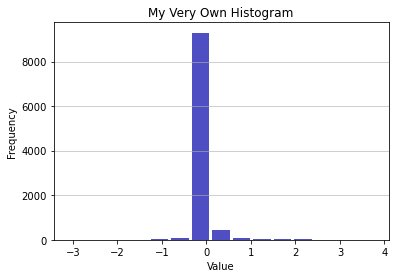

In [32]:
# hist of wmat
n, bins, patches = plt.hist(x=np.matrix.flatten(wmat), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Weights at End')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [60]:
np.array(stim_pos)-np.array(stim_pos)


array([0., 0.])

(0.0, 70.0)

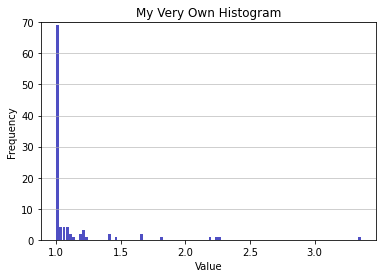

In [33]:
# hist of wmat
n, bins, patches = plt.hist(x=targets, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Targets at End')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [5]:
5*np.cos(130)

-1.8364566522734826